# Meteorología
1. Descargar datos ERA5 (o usar `data/era5_example.nc`).
2. Calcular anomalía de temperatura mensual.
3. Representar evolución temporal en un mapa.
4. (Opcional) Crear animación.


## Como preparar un dataset

Lo primero que hay que hacer es instalar el cliente de Copernicus (CDS API)

Configura tu cuenta de Copernicus (gratis en https://cds.climate.copernicus.eu).
Necesitarás crear un fichero ~/.cdsapirc con tu clave.

Esto da un poco de guerra, así que para el curso me he bajado un ejemplo que os comparto en `data/era5_example.nc`.

En cualquier caso aquí os pongo el script que he utilizado, una vez configurada la cuenta de Copernicus.

In [8]:
pip install cdsapi # Si no lo tienes instalado

Note: you may need to restart the kernel to use updated packages.


### Datos de Copernicus

Nos bajamos los datos de temperatura para el año 2020 (de enero a diciembre) y todos los días, en formato netcdf, para la Península Ibérica

In [9]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': '2m_temperature',
        'year': '2020',
        'month': [f"{m:02d}" for m in range(1, 13)],  # Enero-Diciembre
        'day': [f"{d:02d}" for d in range(1, 32)],    # todos los días
        'time': ['12:00'],  # solo un paso horario para aligerar
        'format': 'netcdf',
        'area': [45, -10, 35, 5],  # Norte, Oeste, Sur, Este (Iberia)
    },
    'era5_example.nc'
)

2025-10-02 12:11:03,726 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-10-02 12:11:04,297 INFO Request ID is 875db7a9-5c8f-43f3-adc7-5cec40fb1482
2025-10-02 12:11:04,582 INFO status has been updated to accepted
2025-10-02 12:11:38,133 INFO status has been updated to running
2025-10-02 12:11:55,283 INFO status has been updated to successful


'era5_example.nc'

In [16]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': 'total_precipitation',
        'year': '2020',
        'month': [f"{m:02d}" for m in range(1, 13)],  # Enero-Diciembre
        'day': [f"{d:02d}" for d in range(1, 32)],    # todos los días
        'time': ['12:00'],
        'format': 'netcdf',
        'area': [45, -10, 35, 5],  # Iberia
    },
    'era5_precip_2020.nc'
)

2025-10-02 12:21:41,111 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-10-02 12:21:41,433 INFO Request ID is df974bc5-2d1b-446b-9ceb-b2c5219a6cea
2025-10-02 12:21:41,493 INFO status has been updated to accepted
2025-10-02 12:21:55,525 INFO status has been updated to running
2025-10-02 12:22:57,585 INFO status has been updated to successful


'era5_precip_2020.nc'

In [ ]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            '2m_temperature',
            'total_precipitation'
        ],
        'year': '2020',
        'month': [f"{m:02d}" for m in range(1, 13)],  # Enero-Diciembre
        'day': [f"{d:02d}" for d in range(1, 32)],    # todos los días
        'time': ['12:00'],
        'format': 'netcdf',
        'area': [45, -10, 35, 5],  # Iberia
    },
    'era5_temp_precip_2020.nc'
)

In [20]:
import xarray as xr

ds1 = xr.open_dataset("era5_example.nc")
ds2 = xr.open_dataset("era5_precip_2020.nc")
ds = xr.merge([ds1, ds2])

## 🔄 Ejemplo de análisis conjunto: temperatura vs precipitación

Usaremos un NetCDF que contiene:
- `t2m` → temperatura a 2 m (K).  
- `tp` → precipitación total (m).  

### Objetivos
1. Calcular la **media mensual de temperatura y precipitación** en toda la Península Ibérica.  
2. Representar:
   - Un **scatterplot** para ver la relación entre T y precipitación.  
   - Un **mapa** de precipitación media con contornos de temperatura.  

In [17]:
import xarray as xr

ds = xr.open_mfdataset("era5_temp_precip_2020.nc", combine="by_coords", engine="netcdf4")

OSError: [Errno -51] NetCDF: Unknown file format: '/Users/galeanojav/Desktop/Docencia/MeteoGeoPy-main/notebooks/era5_temp_precip_2020.nc'

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Abrir dataset con dos variables

ds =xr.open_dataset("era5_temp_precip_2020.nc")

#ds = xr.open_dataset("data/era5_temp_precip_2020.nc", engine='netcdf4')
#ds = xr.open_dataset("data/era5_temp_precip_2020.nc", engine="h5netcdf")
#ds = xr.open_dataset("data/era5_temp_precip_2020.nc", engine="scipy")
print(ds)

# Seleccionar variables
t2m = ds["t2m"] - 273.15          # °C
tp = ds["tp"] * 1000              # mm (ERA5 da en m)

# --- 1. Serie temporal mensual (media sobre Iberia) ---
t2m_monthly = t2m.resample(time="1M").mean(["time", "latitude", "longitude"])
tp_monthly = tp.resample(time="1M").mean(["time", "latitude", "longitude"])

# --- Scatterplot temperatura vs precipitación ---
plt.figure(figsize=(6,6))
sns.scatterplot(x=t2m_monthly.values, y=tp_monthly.values, s=80)
plt.xlabel("Temperatura media (°C)")
plt.ylabel("Precipitación media (mm/día)")
plt.title("Relación temperatura vs precipitación (mensual, 2020)")
plt.grid()
plt.show()

# --- 2. Mapa de precipitación con contornos de temperatura ---
tp_mean = tp.mean("time")
t2m_mean = t2m.mean("time")

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(8,6))
p = tp_mean.plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap="Blues", cbar_kwargs={"label": "Precipitación (mm)"}
)
t2m_mean.plot.contour(
    ax=ax, transform=ccrs.PlateCarree(),
    colors="red", linewidths=1
)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("Precipitación media y contornos de T2m (2020)")
plt.show()

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [14]:
pip install netCDF4

Note: you may need to restart the kernel to use updated packages.


### Importamos las librerías necesarias

 *   numpy: para el manejo de arrays y matrices
 *   matplotlib: para la visualización
 *   obspy: para el procesamiento de sismogramas


Para no tener que depender de internet. He añadido el fichero sismo.mseed en la carpeta data

In [3]:
pip install cartopy # si no lo tienes instalado

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Cargar datos NetCDF

- Variables típicas: t2m (temperatura a 2m en Kelvin).
- Dimensiones: time, latitude, longitude.

Para no tener problemas en la clase los datos están en el directorio `data`del repositorio y los importamos de aquí

In [5]:
ds = xr.open_dataset("data/era5_example.nc")
# Inspeccionar dimensiones y coordenadas
print(ds)
print(ds.coords)

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 366, latitude: 41, longitude: 61)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 3kB 2020-01-01T12:00:00 ... 2020-...
  * latitude    (latitude) float64 328B 45.0 44.75 44.5 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 488B -10.0 -9.75 -9.5 -9.25 ... 4.5 4.75 5.0
    expver      (valid_time) <U4 6kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 4MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-24T08:44 GRIB to CDM+CF via cfgrib-0.9.1...
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 3kB 2020-01-01T12:00:00 ... 2020-...
  * latitude    (latitude) flo

## Convertir a °C y renombrar variables

Hacemos algunos ajustes a los datos:

- Ponemos la temperatura en Grados centígrados
- Renombramos `valid_time` por `time` por comodidad (no es necesario)
- Eliminamos las coordenadas sobrantes con squeeze (por ejemplo 'expver')

In [6]:
t2m = ds['t2m'] - 273.15
t2m = t2m.rename({'valid_time': 'time'})
t2m = t2m.squeeze(drop=True)  # elimina coords sobrantes como 'expver'
t2m

<xarray.DataArray 't2m' (time: 366, latitude: 41, longitude: 61)> Size: 4MB
array([[[11.486237 , 11.531158 , 11.535065 , ...,  5.695221 ,
          5.087799 ,  4.714752 ],
        [11.48819  , 11.531158 , 11.492096 , ...,  6.788971 ,
          6.292877 ,  6.273346 ],
        [11.415924 , 11.486237 , 11.45108  , ...,  8.087799 ,
          7.896393 ,  7.853424 ],
        ...,
        [16.45108  , 16.548737 , 16.63858  , ..., 11.181549 ,
         11.433502 , 11.054596 ],
        [16.521393 , 16.572174 , 16.667877 , ..., 10.882721 ,
         11.095612 , 11.154205 ],
        [16.566315 , 16.636627 , 16.76358  , ..., 10.212799 ,
         10.318268 , 11.111237 ]],

       [[13.459381 , 13.37735  , 13.258209 , ...,  3.4671936,
          4.5589905,  5.051178 ],
        [13.494537 , 13.4086   , 13.267975 , ...,  3.441803 ,
          4.7308655,  4.943756 ],
        [13.5121155, 13.398834 , 13.217194 , ...,  4.521881 ,
          5.3285217,  5.426178 ],
...
        [14.156158 , 14.040924 , 13.95108  , ..., 12.031158 ,
         12.001862 , 10.816315 ],
        [14.302643 , 14.163971 , 14.095612 , ..., 11.339752 ,
         11.691315 , 11.525299 ],
        [14.529205 , 14.386627 , 14.302643 , ...,  9.54483  ,
         10.302643 , 11.13858  ]],

       [[ 9.577789 ,  9.735992 ,  9.864899 , ...,  2.3746643,
          4.2672424,  4.8785706],
        [ 9.706696 ,  9.917633 , 10.077789 , ...,  2.292633 ,
          4.464508 ,  4.167633 ],
        [ 9.786774 , 10.038727 , 10.048492 , ...,  3.6168518,
          4.870758 ,  4.413727 ],
        ...,
        [15.314117 , 15.243805 , 15.163727 , ...,  9.370758 ,
          9.234039 ,  8.480133 ],
        [15.513336 , 15.35318  , 15.206696 , ...,  9.444977 ,
          9.411774 ,  9.226227 ],
        [15.60318  , 15.437164 , 15.308258 , ...,  8.698883 ,
          8.689117 ,  9.210602 ]]], shape=(366, 41, 61), dtype=float32)
Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 3kB 2020-01-01T12:00:00 ... 2020-12-31T1...
  * latitude   (latitude) float64 328B 45.0 44.75 44.5 44.25 ... 35.5 35.25 35.0
  * longitude  (longitude) float64 488B -10.0 -9.75 -9.5 -9.25 ... 4.5 4.75 5.0
    expver     (time) <U4 6kB ...

## Calculamos la climatología mensual

In [16]:
mensual = t2m.resample(time="1M").mean()
media_anual = mensual.mean("time")
anomalia_agosto2020 = mensual.sel(time="2020-08") - media_anual # Anomalía agosto 2020 con media anual
print(float(anomalia_agosto2020.min()), float(anomalia_agosto2020.max()))

1.8346843719482422 12.870996475219727


/Users/galeanojav/miniconda3/lib/python3.12/site-packages/xarray/groupers.py:498: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


### Calculamos la anomalía de Agosto en función de la media anual

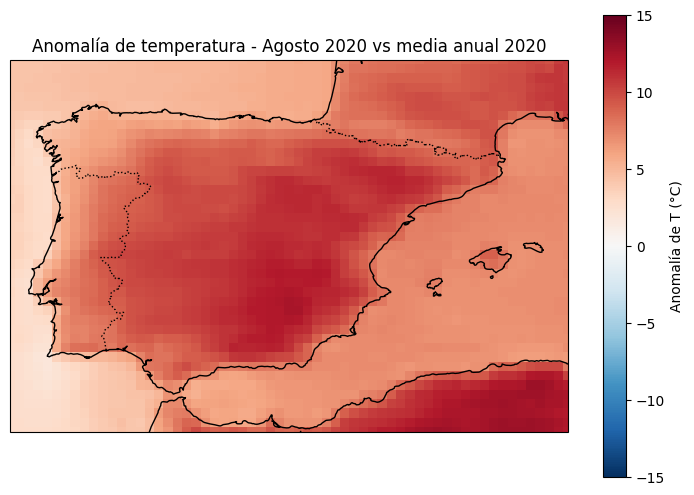

In [17]:
anomalia_agosto2020 = anomalia_agosto2020.sortby("latitude")

fig, ax = plt.subplots(figsize=(9,6), subplot_kw={'projection': ccrs.PlateCarree()})

anomalia_agosto2020.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-15, vmax=15,   # rango centrado en 0
    cbar_kwargs={'label': 'Anomalía de T (°C)'}
)

ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_extent([-10, 5, 35, 45], crs=ccrs.PlateCarree())
ax.set_title("Anomalía de temperatura - Agosto 2020 vs media anual 2020")

plt.show()

### Calculamos la anomalía de enero en función de la media anual

Básicamente hacemos lo mismo que antes pero con el mes de enero

In [18]:
# Anomalía de enero 2020
anomalia_enero2020 = mensual.sel(time="2020-01") - media_anual

# Asegurar que las latitudes estén en orden
anomalia_enero2020 = anomalia_enero2020.sortby("latitude")

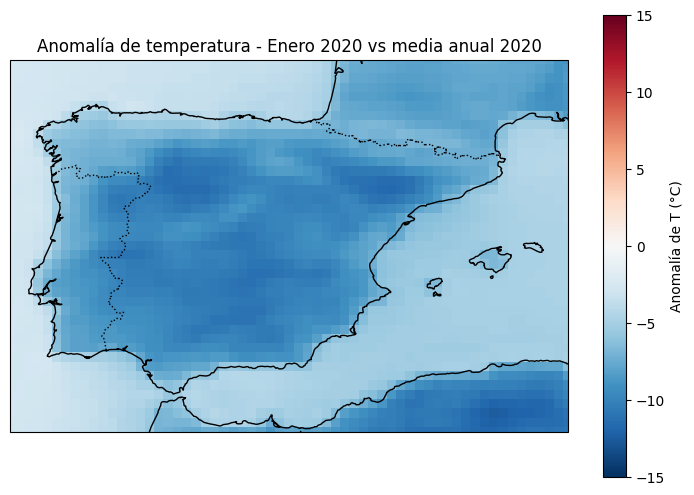

In [20]:
 # Graficamos la anomalía de enero 
fig, ax = plt.subplots(
    figsize=(9, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

anomalia_enero2020.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-15, vmax=15,   # mismo rango que agosto para comparar
    cbar_kwargs={'label': 'Anomalía de T (°C)'}
)

ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_extent([-10, 5, 35, 45], crs=ccrs.PlateCarree())
ax.set_title("Anomalía de temperatura - Enero 2020 vs media anual 2020")

plt.show()

## 2. Estudiamos la anomalía de temperatura en 5 años (2016 a 2020)

En realidad, en el caso anterior hemos hecho una chapucilla, porque hemos estudiado la anomalía con respecto a la media anual. Lo que deberíamos hacer es con respecto a la media de 5 años (2016-2020).

In [21]:
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': '2m_temperature',
        'year': [str(y) for y in range(2016, 2021)],  # 2016-2020
        'month': [f"{m:02d}" for m in range(1, 13)],  # Enero-Diciembre
        'day': [f"{d:02d}" for d in range(1, 32)],   # todos los días
        'time': ['12:00'],  # solo un paso horario diario (ligero)
        'format': 'netcdf',
        'area': [45, -10, 35, 5],  # Norte, Oeste, Sur, Este (Iberia)
    },
    'era5_2016_2020.nc'
)


2025-09-25 16:50:19,108 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-25 16:50:19,110 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-25 16:50:19,746 INFO Request ID is 46e7659f-afdd-4db3-93bb-c71eec4cb2c3
2025-09-25 16:50:19,995 INFO status has been updated to accepted
2025-09-25 16:50:33,526 INFO status has been updated to successful


'era5_2016_2020.nc'

Igual que antes para no depender de internet, guardamos el fichero  csv con los datos en la carpeta data

In [24]:
# --- 1. Cargar datos ---
ds1 = xr.open_dataset("era5_2016_2020.nc")

# Pasar a °C y renombrar eje temporal
t2m1 = ds1['t2m'] - 273.15
t2m1 = t2m1.rename({'valid_time': 'time'})
t2m1 = t2m1.squeeze(drop=True)  # eliminar coords sobrantes (ej. expver)


In [27]:
# --- 2. Calcular climatología mensual (2016-2019) ---
t2m_hist = t2m1.sel(time=slice("2016-01-01", "2019-12-31"))
climatologia = t2m_hist.groupby("time.month").mean("time")

# --- 3. Calcular anomalías (2020 - climatología) ---
anomalias = t2m1.groupby("time.month") - climatologia

# Seleccionar anomalía de agosto 2020
anomalia_agosto2020 = anomalias.sel(time="2020-08").mean("time")

# Ordenar latitud
anomalia_agosto2020 = anomalia_agosto2020.sortby("latitude")
print(float(anomalia_agosto2020.min()), float(anomalia_agosto2020.max()))

-3.171595811843872 2.410621404647827


### Pintamos, ahora sí, las anomalías de agosto de 2020

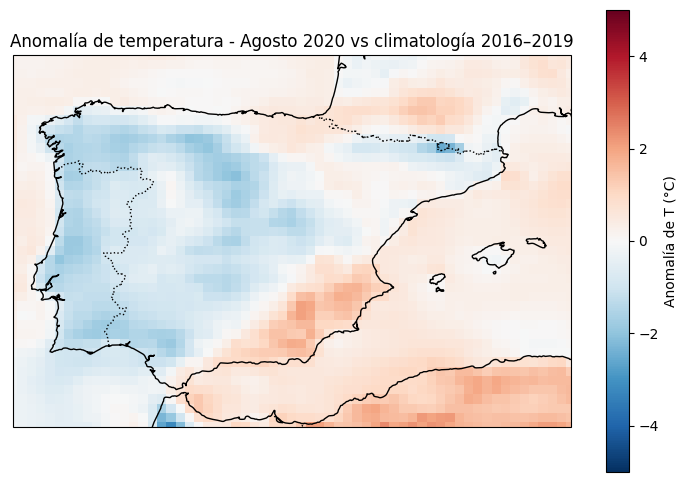

In [28]:
# --- 4. Graficar ---
fig, ax = plt.subplots(
    figsize=(9, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

anomalia_agosto2020.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-5, vmax=5,   # escala centrada en 0
    cbar_kwargs={'label': 'Anomalía de T (°C)'}
)

ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_extent([-10, 5, 35, 45], crs=ccrs.PlateCarree())
ax.set_title("Anomalía de temperatura - Agosto 2020 vs climatología 2016–2019")

plt.show()

In [29]:
# Seleccionar anomalía de enero 2020
anomalia_enero2020 = anomalias.sel(time="2020-01").mean("time")

# Ordenar latitud
anomalia_enero2020 = anomalia_enero2020.sortby("latitude")
print(float(anomalia_enero2020.min()), float(anomalia_enero2020.max()))

-1.9943873882293701 2.4408271312713623


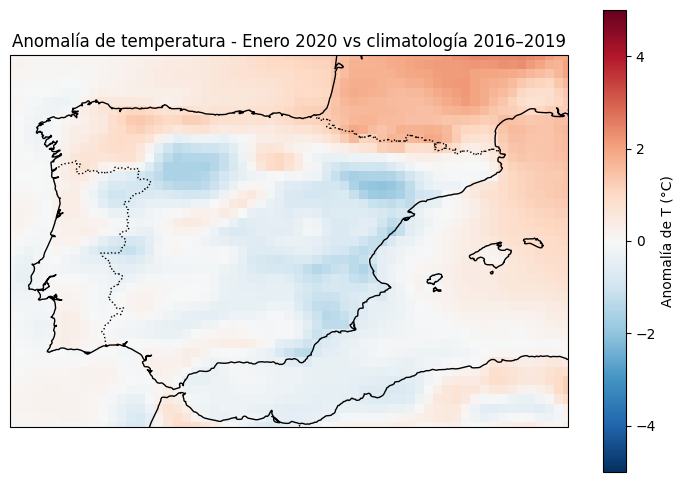

In [30]:
# --- 4. Graficar ---
fig, ax = plt.subplots(
    figsize=(9, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

anomalia_enero2020.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-5, vmax=5,   # escala centrada en 0
    cbar_kwargs={'label': 'Anomalía de T (°C)'}
)

ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_extent([-10, 5, 35, 45], crs=ccrs.PlateCarree())
ax.set_title("Anomalía de temperatura - Enero 2020 vs climatología 2016–2019")

plt.show()

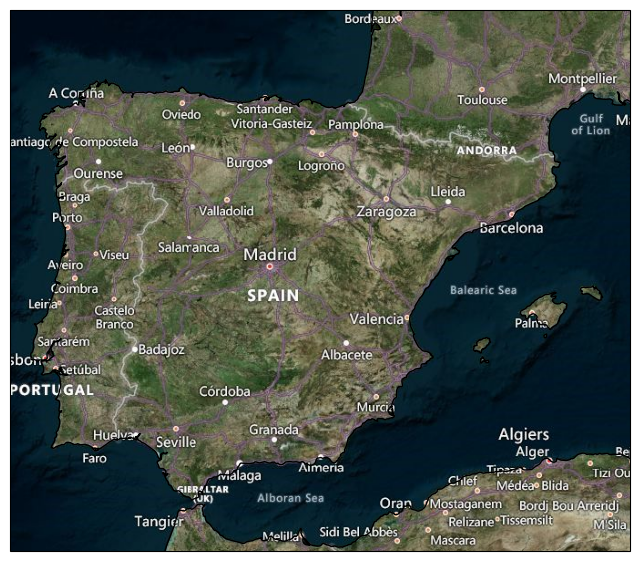

In [21]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

# Tile satelital (ESRI)
tiler = cimgt.QuadtreeTiles()
proj = tiler.crs

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=proj)
ax.set_extent([-10, 5, 35, 45])  # Iberia

ax.add_image(tiler, 6)  # nivel de zoom
ax.coastlines()
plt.show()